<a href="https://colab.research.google.com/github/karimtito/Machine_learning_NLP_Yelp/blob/master/Sentiment_analysis_Yelp_ENSAE_TIT_Parziale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1 Importing required librairies, loading and quickly exploring the data 


In [45]:
import pandas as pd                         #used to load csv files and 
import numpy as np
import re                                   #regular expressions use to clean the text
import string
from tqdm import tqdm
from time import time
from wordcloud import WordCloud
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import TreebankWordTokenizer
nltk.download('punkt')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

nltk.download('stopwords')

nltk.download('averaged_perceptron_tagger')

nltk.download('wordnet')
import spacy
tokenizer = spacy.load("en_core_web_sm")
import os

n = 30000                                 #total number of observations
s = 15000                                 #number of samples
prop_train_test = 0.9                          #proportion of samples for training and testing vs. validation
prop_train = 0.8                               #proportion of samples for training vs. testing



import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
df = pd.read_csv("https://raw.githubusercontent.com/karimtito/Machine_learning_NLP_Yelp/master/yelp_review_30K.csv",nrows = s)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [46]:

%load_ext autoreload
%autoreload 2

import torch                                # Importation of PyTorch to train the LSTM
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(1)

from sklearn.tree import plot_tree                          #used to plot the tree
from sklearn.metrics import confusion_matrix                #use the obtain ROC and other metrics for all the models


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
positive_review = lambda x : np.heaviside(x-3,1)         
#Nota Bene: to simplify we use '1' for a positive review and '0' for a negative review, even though we are more interested in the 
#performance for labelling negative reviews i.e. to detect them well
labels = np.array(df["stars"].apply(positive_review))
df["label"] = labels
pos_freq = labels.mean()                         #sample frequency of positive reviews
df.head(10),labels.mean()  #we look at the 10 first rows and at the sample frequency of positive reviews


(   Unnamed: 0  stars                                               text  label
 0           0      5  Super simple place but amazing nonetheless. It...    1.0
 1           1      5  Small unassuming place that changes their menu...    1.0
 2           2      5  Lester's is located in a beautiful neighborhoo...    1.0
 3           3      4  Love coming here. Yes the place always needs t...    1.0
 4           4      4  Had their chocolate almond croissant and it wa...    1.0
 5           5      5  Cycle Pub Las Vegas was a blast! Got a groupon...    1.0
 6           6      4  Who would have guess that you would be able to...    1.0
 7           7      4  Always drove past this coffee house and wonder...    1.0
 8           8      3  Not bad!! Love that there is a gluten-free, ve...    1.0
 9           9      5  Love this place!\n\nPeggy is great with dogs a...    1.0,
 0.8195333333333333)

We see that there is a pretty big imbalance : about 80% of positive reviews vs. 20% of negative reviews


> One thing that can be done to improve on that is to sample weights in the training of algorithms

The idea is to consider a weighted version of the empirical loss $l_{n,\omega}(f,D_n) = \sum_{i :Y_i = 0}\omega_{0}l(f(X_i),Y_i)+\sum_{i :Y_i = 1}\omega_{1}l(f(X_i),Y_i)$, with the condition $\omega_{0}\#\{i :Y_i = 0\}+\omega_{1}\#\{i :Y_i = 1\}=1$. For example one can take $\omega_0 = (1-N_1/n)/N_0$ and $\omega_1 = \frac{1}{n}$. We use this approach to train the CART algorithm with Bag-of-words.




Below we drop unecessary/unusable columns and rows and we get the training, testing and validation labels.

In [48]:
df2 =df.drop(labels = ['Unnamed: 0', 'stars'],axis =1)
print(df2.shape)
df2.dropna()
Y = df2.label.to_numpy()
n_train_test = int(s*prop_train_test)
n_train = int(n_train_test*prop_train)
Y_train,Y_test,Y_validation = Y[:n_train],Y[n_train:n_train_test],Y[n_train_test:]


(15000, 2)


In [0]:
sample_weights = (1./s)*np.ones(s)
N_0,N_1 = s-Y.sum(),Y.sum()
sample_weights[Y==0] = (1-N_1/n)/N_0

### Wordcloud visualization:
A visualization method that displays how frequently words appear in a given body of text, by making the size of each word proportional to its frequency. All the words are then arranged in a cluster or cloud of words.

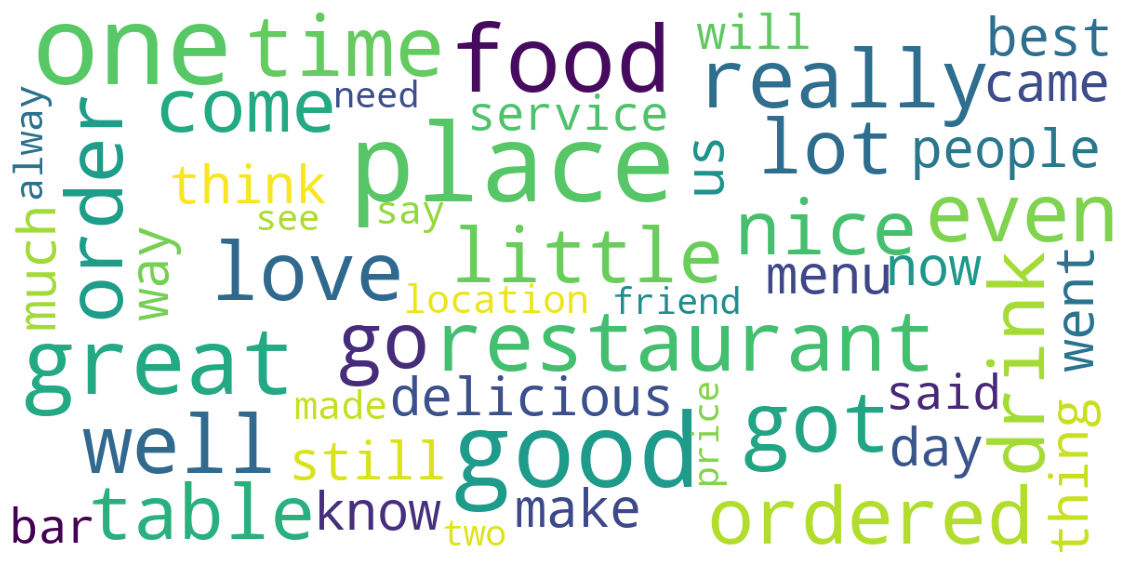

In [11]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 50,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
df["text"]  = df2["text"].apply(lambda x : x.replace('\n',''))
# print wordcloud
show_wordcloud(df["text"].to_list())

## 2. Implementation of LSTM with Word2vec embedding
We begin by cleaning the corpus of reviews and training a Word2Vec embedding.

In [12]:
def tokenized_sentence(corpus):
  tokenizer = TreebankWordTokenizer()
  tokenized_sentences = []
  for sample in tqdm(corpus):
    # separating sentences
    for sentence in sent_detector.tokenize(sample):
      tokens = tokenizer.tokenize(sentence)
      tokens = list(map(lambda x: x.lower() , tokens))
      tokens = list(map(lambda x: x.replace("\n"," ").replace("\r","").replace(","," ").replace("."," ").replace("!"," ").replace("\\/", " ") , tokens))
      tokens = [ t for t in tokens if len(t)>1 ]
      tokenized_sentences.append(tokens)
  return tokenized_sentences

def clean_corpus(corpus, threshold=50):
  tokenized_sentences = tokenized_sentence(corpus)
  phrases = Phrases(tokenized_sentences, threshold=threshold)

  # This lets you use it with less RAM and faster processing.
  # But it will no longer be possible to update the detector with new training 
  # samples
  phraser = Phraser(phrases)

  # Merging multi-word expressions in the tokenization
  clean_corpus = []
  for sentence in tokenized_sentences:
    clean_corpus.append(phraser[sentence])
  
  return clean_corpus


corpus = clean_corpus(df2.text.array[:n_train])
from gensim.models import Word2Vec
from multiprocessing import cpu_count

cpu = cpu_count()
print('The virtual instance has {} cpus, that will be used to train the word2vec model'.format(cpu))


100%|██████████| 10800/10800 [00:14<00:00, 725.49it/s]


The virtual instance has 4 cpus, that will be used to train the word2vec model


In [13]:
corpus[1237]

['nothing',
 'too',
 'outside',
 'of',
 'the',
 'box',
 'but',
 'that',
 "'s",
 'not',
 'necessarily',
 'bad',
 'thing']

We now an ad hoc train the Word2Vec representation on our cleaned corpus.

In [0]:
d= 25
model = Word2Vec(corpus, size=d, window=5, min_count=3, workers=cpu)
model.train(corpus, total_examples=len(corpus), epochs=10)
model_wv = model.wv

In [16]:
model_wv.save("./word2vec50d.model")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


We next check qualitatively the relevance of the Word2vec embeding

In [0]:
def most_similar(w,n=5):
  if w in model_wv:
    closest_ws =[w[0] for w in model_wv.most_similar(w, topn=n)]
    print("According to our ad-hoc Word2vec, the closest {} words to \"{}\" " 
    "are: \n {}".format( n, w, '"'+'",\n then "'.join(closest_ws)+'"'))
  else:
    print(w, " could not be found in the Word2vec vocabulary")

In [18]:
most_similar("restaurant")
most_similar("amazing")
most_similar("confusing")

According to our ad-hoc Word2vec, the closest 5 words to "restaurant" are: 
 "location",
 then "place",
 then "area",
 then "theater",
 then "hotel"
According to our ad-hoc Word2vec, the closest 5 words to "amazing" are: 
 "awesome",
 then "fantastic",
 then "excellent",
 then "incredible",
 then "fabulous"
According to our ad-hoc Word2vec, the closest 5 words to "confusing" are: 
 "tight",
 then "tricky",
 then "dated",
 then "sensitive",
 then "sparse"


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


The embedding seems good enough to train directly an LSTM network on top of it.

### 2.2 Training an LSTM with the trainded Word2Vec embedding

We first write a function to embed any sequence using the above Word2Vec model

In [0]:
def prepare_embedding(seq, embedding =model_wv ):
    idxs = [embedding[w] if w in corpus else np.random.normal(size = d) for w in seq]
    # note : Word2Vec can't handle out-of-vocabulary, thus we resort to a random vector for out-vocabulary words
    idxs = torch.tensor(idxs,dtype =torch.float).unsqueeze(0)
    return idxs

  

We then clean and tokenize the train,test and validation data using an ad-hoc tokenizer.

In [0]:
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
def clean_tokenized_text(text):
    #Ad-hoc cleaning and tokenizing function
    # lower text
    text = text.lower()
    # remove line jumps and tabs
    text = text.replace("\n", '').replace('\r', '').replace('\t','').replace("\\/",'-').replace("!",' ').replace(".",' ').replace(","," ")
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]           # The character "'" is not considered as punctation
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]      
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]   # we are not interested in one-character expressions such as 'a' or '&'
    # join all
    return(text)   

df3 = df2.text.apply(clean_tokenized_text)

In [52]:
x  = df3.to_numpy()
data = []
for i in range(len(x)):
    data.append((x[i], Y[i]))                 # vector Y is defined above and simply contains the labels
training_data = data[:n_train]
test_data = data[n_train:n_train_test]
validation_data = data[n_train_test:]
print("Got {} training examples, {} test examples, {} validation examples".format(len(training_data), len(test_data),len(validation_data)))


Got 10800 training examples, 2700 test examples, 1500 validation examples


In [0]:
# defining the classifier model

class SequenceLabeller(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, num_classes=2, sequence_model="LSTM"):
        super(SequenceLabeller, self).__init__()

        self.hidden_dim = hidden_dim
        #self.word_embeddings  /!\ no embedding layer we use directly a pre-trained word2vec
        
        if sequence_model == "LSTM":
            # The LSTM takes word embeddings as inputs, and outputs hidden states
            # with dimensionality hidden_dim.
            self.seq = nn.LSTM(embedding_dim, hidden_dim,batch_first=True)
        else:
            raise(Exception("Sequence model {} not supported".format(sequence_model)))

        # The linear layer that maps from hidden state space to class space
        self.hidden2tag = nn.Linear(hidden_dim, num_classes)

    def forward(self, embeded_sentence):
        seq_output, (h_n,c_n) = self.seq(embeded_sentence)
        tag_space = self.hidden2tag(seq_output)
        # Although we will be performing binary classification, this is a 
        # general implementation displaying what should be done for n_classes>2
        tag_scores = F.log_softmax(tag_space, dim=2) # Computationally efficient for the criterion
        return tag_scores

We run a first pass without training to check that everything works.





In [54]:
model = SequenceLabeller(embedding_dim= d, hidden_dim = 30) 
inputs = prepare_embedding(training_data[0][0])
with torch.no_grad():
    sent_scores = model(torch.cat([inputs]))
    print("Input tokens {} scores {} ".format(inputs, np.exp(sent_scores)))

Input tokens tensor([[[ 1.9112e+00, -2.2103e+00, -4.3647e-01,  2.1100e+00,  9.6652e-01,
           1.2168e+00,  5.9171e-01,  4.7506e-01, -3.9234e-01, -1.1213e+00,
          -2.4166e-02,  6.5831e-01,  3.0170e-01, -4.9414e-02,  4.9106e-02,
          -5.1305e-01, -2.0335e+00,  1.3884e+00, -1.5393e+00, -3.2886e-01,
           9.3323e-01, -5.5576e-01,  1.4451e+00,  9.9448e-01, -1.6593e+00],
         [-6.9960e-02,  1.1995e+00,  6.8070e-01,  4.6019e-01, -1.5150e+00,
           1.0827e+00,  1.8741e+00,  1.6282e+00,  1.2344e-01, -4.6022e-01,
          -8.0915e-01,  8.4770e-01,  7.7277e-01,  8.0708e-01,  4.5674e-01,
          -1.2088e+00,  1.5459e+00,  1.2602e-01, -9.7572e-01, -1.9069e+00,
           4.1210e-02, -1.4017e+00,  1.1802e-01, -2.7362e-01,  4.9176e-02],
         [ 1.3796e+00, -5.6618e-01, -3.4138e-01,  9.1363e-01, -4.5381e-01,
          -7.9371e-01,  6.1957e-01,  3.6740e-01,  8.9039e-01, -5.0401e-02,
           4.7010e-01, -8.7338e-02,  9.5954e-01, -1.2830e+00, -7.7789e-01,
          

As one may expect, without training the network does give much better than a fair coin.
We can now train the model, using a stochastic gradient descent.

In [0]:
loss_function = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.08) 
model

In [55]:

def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] if w in to_ix else len(to_ix) for w in seq]
    idxs = torch.tensor(idxs, dtype=torch.long).unsqueeze(0)
    return idxs

prepare_sequence([1],tag_to_ix)

tensor([[0]])

In [56]:


from torch.nn.functional import one_hot
n_epochs = 10
tag_to_ix = {0.0: 0, 1.0: 1}
for epoch in range(n_epochs): 
    loss_mean_ep = 0
    n_sample = 0
    t = time()
    for sentence, tags in training_data:
        if len(sentence) < 2: continue
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()
        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_embedding(sentence,embedding=model_wv)
        #import pdb
        #pdb.set_trace()
        targets = prepare_sequence([tags], tag_to_ix)
        one_hot_targets = one_hot(targets.squeeze(0), num_classes=len(tag_to_ix))
        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)
        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        #import pdb
        #pdb.set_trace()
        # print(tag_scores.shape, one_hot_targets.shape)
        loss = loss_function(tag_scores, one_hot_targets)
        loss_mean_ep += loss
        n_sample += 1
        loss.backward()
        optimizer.step()
    print("Epoch {} loss {:0.4f} ".format(epoch, loss_mean_ep/n_sample),"Taking {} secs".format(time()-t))

KeyboardInterrupt: ignored

In [0]:
torch.save(model.state_dict(),'.\lstm3.pt')

Qualitative evaluation of the model:


In [0]:
with torch.no_grad():
  label_count = [0, 0]
  n_samples = 5
  for sentence, tag in test_data:
          label_count[int(tag)] += 1
          if label_count[int(tag)] <= n_samples:
            sentence_in = prepare_embedding(sentence)
            sentence_tag = 'Positive' if tag==1 else 'Negative'
            tag_scores = model(sentence_in)
            positive_score = torch.mean(torch.exp(tag_scores.squeeze(0)[:, 1])).item()
            print("{} sentence scored {} \"{}\"."
            "".format(sentence_tag, positive_score,' '.join(sentence)) )
          if (label_count[0] >= n_samples) and (label_count[1] >= n_samples):
            break

Quantitative evaluation of the model:

In [0]:
from sklearn.metrics import roc_auc_score, classification_report

ground_truth, scores = [], []
with torch.no_grad():
  for sentence, tag in test_data:
    sentence_in = prepare_embedding(sentence)
    ground_truth.append(tag)
    tag_scores = model(sentence_in)
    scores.append(torch.mean(torch.exp(tag_scores.squeeze(0)[:, 1])).item())

print("The AUC is ", roc_auc_score(ground_truth, scores))
print("Classification report:\n", classification_report(ground_truth, np.array(scores)>0.5))

In [0]:
C = confusion_matrix(ground_truth,np.array(scores)>0.5)
neg_pred_perf = C[0,0]/(C[0,0]+C[1,0])
fals_disc_rate = C[1,1]/(C[1,1]+C[1,0])
neg_pred_perf,fals_disc_rate

## 3. Classification decision trees with Bag-of-Words features




We now use impelment a Bag of Words approach. We first tokenize each review and we also use the tokenized whole corpus to define a dictionnary.

In [292]:

#we begin by lowering the review, removing the line breaks and numbers
df3 = df2.text.apply(lambda x: re.sub(r'[0-9]+', '', x.lower().rstrip())) 

x = df3.to_numpy()
df2.head()

,text,label
0,Super simple place but amazing nonetheless. It...,1.0
1,Small unassuming place that changes their menu...,1.0
2,Lester's is located in a beautiful neighborhoo...,1.0
3,Love coming here. Yes the place always needs t...,1.0
4,Had their chocolate almond croissant and it wa...,1.0


We then build the Bag-of-words features of the text using a feature extractor from Scikit-learn.

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
nb_max_feat = 5000
vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = 'english', max_features = nb_max_feat) 
train_data_features = vectorizer.fit_transform(x)
z =vectorizer.transform([df2.text.array[6]]).toarray()
nb_feat = z.shape[0]

In [0]:
X = train_data_features.toarray()
X_train,X_test,X_validation= X[:n_train],X[n_train:n_train_test],X[n_train_test:]


In [0]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

clf = DecisionTreeClassifier(max_depth=5,random_state= 0)

clf = clf.fit(X_train,Y_train)

In [0]:
Y_hat_test2 = clf.predict(X_test)
C = confusion_matrix(Y_test,Y_hat_test2)

In [317]:
neg_pred_perf = C[0,0]/(C[0,0]+C[1,0])
fals_disc_rate = C[1,1]/(C[1,1]+C[1,0])
fpr = C[0,1]/(C[0,1]+C[1,1])
tpr = C[ 1,1]/(C[1,1]+C[0,1])
neg_pred_perf,fals_disc_rate

(0.759493670886076, 0.9732142857142857)

We see that naively training a decision tree with a maximum depth of 5, we already have pretty good results according to our metrics.
Since training the decision trees is not too costly, we can proceed to a model selection on the depth of the tree using the test set.

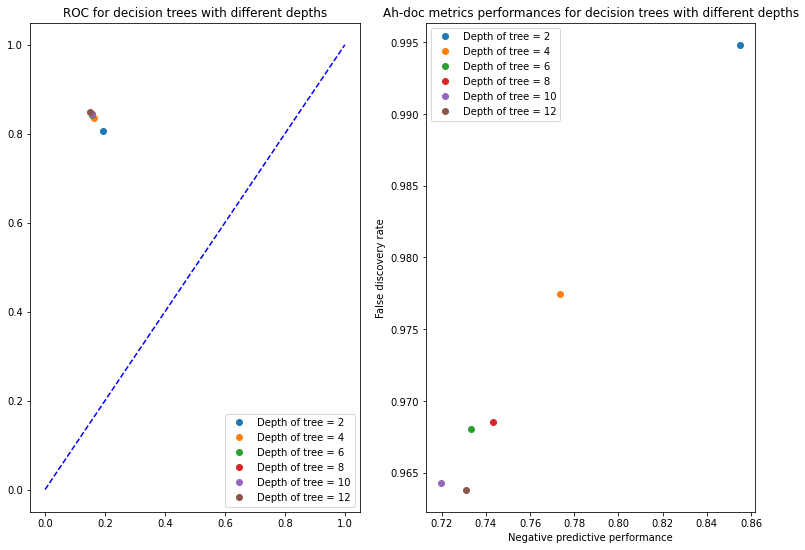

In [318]:
range_depth = np.arange(2,14,2)
neg_pred_ = []
false_disc_ = []
fpr_ = []
tpr_ = []
T = np.linspace(0,1,100)
plt.figure(figsize=( 13,9))
plt.subplot(1,2,1)
plt.plot(T,T,'b--')
for d in range_depth:
  clf = DecisionTreeClassifier(max_depth=d,random_state=0)
  clf = clf.fit(X_train,Y_train)
  Y_hat_test = clf.predict(X_test)
  C = confusion_matrix(Y_test,Y_hat_test)
  neg_pred_perf = C[0,0]/(C[0,0]+C[1,0])
  fals_disc_rate = C[1,1]/(C[1,1]+C[1,0])
  fpr = C[0,1]/(C[0,1]+C[1,1])
  tpr = C[ 1,1]/(C[1,1]+C[0,1])
  neg_pred_.append(neg_pred_perf)
  false_disc_.append(fals_disc_rate)
  fpr_.append(fpr)
  tpr_.append(tpr)
  plt.plot(fpr,tpr,'o',label = "Depth of tree = {}".format(d))

plt.legend()
plt.title("ROC for decision trees with different depths")
plt.savefig("ROC_CART")
plt.subplot(1,2,2)
plt.xlabel("Negative predictive performance")
plt.ylabel("False discovery rate")
for i in range(len(range_depth)):
  d=range_depth[i]
  plt.plot(neg_pred_[i],false_disc_[i],'o',label = "Depth of tree = {}".format(d))

plt.legend()
plt.title("Ah-doc metrics performances for decision trees with different depths")
plt.savefig("adhocCART")






We see that overall the decision trees have pretty good perfomances. We see that the ROC improves gradually as depth is increased. On the others hand, for the metrics we chose to focus on, we see that the perfomances seems to decrease for larger models. Given the perfomances, we choose to use a depth of *4* for the validation. \\
We next plot the decision tree obtained for $depth = 4$.

[Text(418.5, 679.5, 'X[4942] <= 0.5\ngini = 0.293\nsamples = 10800\nvalue = [1923, 8877]'),
 Text(209.25, 407.69999999999993, 'X[218] <= 0.5\ngini = 0.276\nsamples = 10603\nvalue = [1751, 8852]'),
 Text(104.625, 135.89999999999998, '\n  (...)  \n'),
 Text(313.875, 135.89999999999998, '\n  (...)  \n'),
 Text(627.75, 407.69999999999993, 'X[2592] <= 1.5\ngini = 0.222\nsamples = 197\nvalue = [172, 25]'),
 Text(523.125, 135.89999999999998, '\n  (...)  \n'),
 Text(732.375, 135.89999999999998, '\n  (...)  \n')]

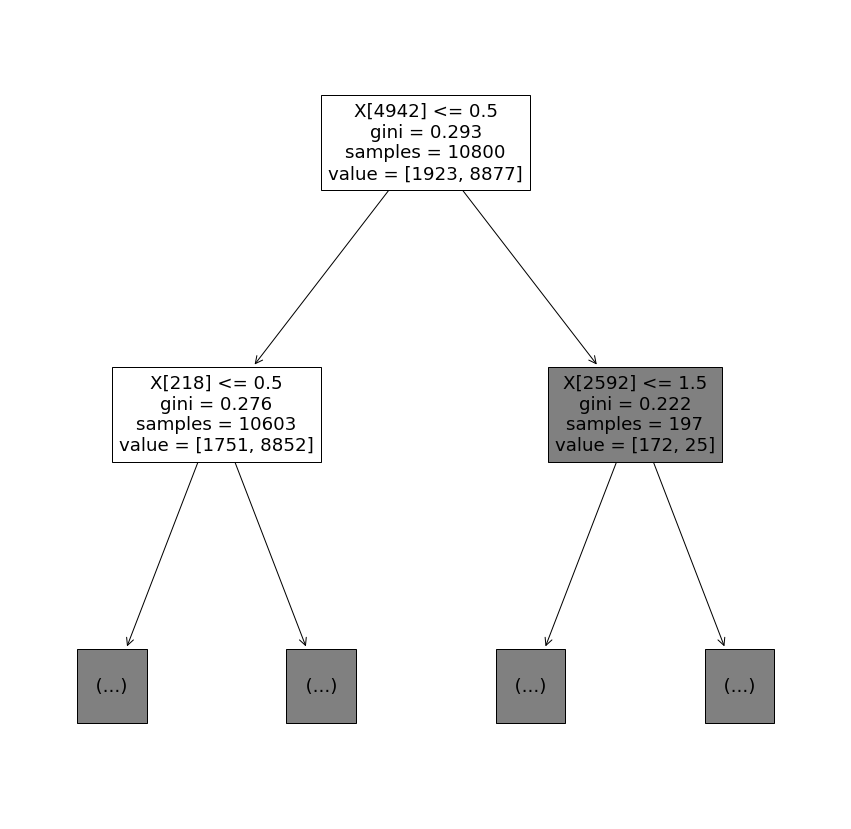

In [326]:

clf = DecisionTreeClassifier(max_depth=4,random_state=0)
plt.figure(figsize=(15, 15))
plot_tree(clf.fit(X_train,Y_train),max_depth=1) 

To interprete the tree plot we determine the word associated with each of the 3 first nodes. 

In [323]:
X = np.zeros(5000)
X[4942] = 1
vectorizer.inverse_transform(X)  # we use the inverse transform of the Bag-of-words feature extractor above

[array(['worst'], dtype='<U19')]

In [324]:
X = np.zeros(5000)
X[218] = 1
vectorizer.inverse_transform(X)

[array(['asked'], dtype='<U19')]

In [325]:
X = np.zeros(5000)
X[2592] = 1
vectorizer.inverse_transform(X)

[array(['love'], dtype='<U19')]

Here we see that the first words selected by the model are "worsted", "asked" and "love", which makes sense qualitatively. \\
We next use test samples to verify qualitatively the performance of the DT.
Finally we compute the performance of the selected tree on the validation set.

In [0]:
Y_hat_validation = clf.predict(X_validation)

In [333]:

C = confusion_matrix(Y_validation,Y_hat_validation)
neg_pred_perf = C[0,0]/(C[0,0]+C[1,0])
fals_disc_rate = C[1,1]/(C[1,1]+C[1,0])
fpr = C[0,1]/(C[0,1]+C[1,1])
tpr = C[ 1,1]/(C[1,1]+C[0,1])
neg_pred_perf,fals_disc_rate

(0.625, 0.9790372670807453)

## 4 Training a LSTM nn with it's own embedding layer

We initally wanted to train a bidirectional LSTM but we had trouble with training it properly. We at least get a good comparison between an LSTM with a pre-trained Word2vec layer, and an LSTM with it's own embedding layer.

To keep things fare with the LSTM above, we give the same dimensions for it's embedding and hidden layers.

### Building the features for the model

In [0]:
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_tokenized_text(text):
    #Ad-hoc cleaning and tokenizing of the text
    # lower text
    text = text.lower()
    # remove line jumps and tabs
    text = text.replace("\n", '').replace('\r', '').replace('\t','').replace("\\/",'-').replace("!",' ').replace(".",' ').replace(","," ")
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]           # The character "'" is not considered as punctation
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]      
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]   # we are not interested in one-character expressions such as 'a' or '&'
    # join all
    return(text)   





In [0]:
df2.text=df["text"].apply(lambda x: clean_tokenized_text(x))


In [25]:
"eerj j \n stuff\n".replace("\n",'')

'eerj j  stuff'

In [26]:
df2.text.head(10)

0    [super, simple, place, amaze, nonetheless, aro...
1    [small, unassuming, place, change, menu, every...
2    [lester's, locate, beautiful, neighborhood, si...
3    [love, come, yes, place, always, need, floor, ...
4    [chocolate, almond, croissant, amazing, light,...
5    [cycle, pub, la, vega, blast, get, groupon, re...
6    [would, guess, would, able, get, fairly, decen...
7    [always, drive, past, coffee, house, wonder, b...
8    [bad, love, gluten-free, vegan, version, chees...
9    [love, place, peggy, great, dog, great, job, p...
Name: text, dtype: object

In [27]:
x = df2.text.to_numpy()
data = []
for i in range(len(x)):
    data.append((x[i], Y[i]))
training_data = data[:n_train]
test_data = data[n_train:n_train_test]
validation_data = data[n_train_test:]
print("Got {} training samples, {} test samples, {} validation samples".format(len(training_data), len(test_data),len(validation_data)))


Got 10800 training samples, 2700 test samples, 1500 validation samples


In [0]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] if w in to_ix else len(to_ix) for w in seq]
    idxs = torch.tensor(idxs, dtype=torch.long).unsqueeze(0)
    return idxs

word_to_ix = {}
tag_to_ix = {}
for review, tag in training_data:
    if tag not in tag_to_ix:
        tag_to_ix[tag] = len(tag_to_ix)
    for word in review:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)



In [29]:
training_data[6]

(['would',
  'guess',
  'would',
  'able',
  'get',
  'fairly',
  'decent',
  'vietnamese',
  'restaurant',
  'east',
  'york',
  'quite',
  'chinatown',
  'term',
  'price',
  'slightly',
  'higher',
  'definitely',
  'one',
  'good',
  'vietnamese',
  'restaurant',
  'outside',
  'neighbourhood',
  'time',
  'go',
  'chinatown',
  'next',
  'best',
  'thing',
  'street',
  'far',
  'item',
  'try',
  'phos',
  'beef',
  'chicken',
  'vegetarian',
  'disappoint',
  'especially',
  'chicken',
  'pho',
  'next',
  'time',
  'go',
  'back',
  "i'm",
  'go',
  'try',
  'banh',
  'cuon',
  'steam',
  'rice',
  'noodle',
  'vermicelli'],
 1.0)

In [0]:
# defining the classifier model

class SequenceLabeller(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, num_classes, sequence_model="LSTM"):
        super(SequenceLabeller, self).__init__()

        self.hidden_dim = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        if sequence_model == "LSTM":
            # The LSTM takes word embeddings as inputs, and outputs hidden states
            # with dimensionality hidden_dim.
            self.seq = nn.LSTM(embedding_dim, hidden_dim,batch_first=True)
        else:
            raise(Exception("Sequence model {} not supported".format(sequence_model)))

        # The linear layer that maps from hidden state space to class space
        self.hidden2tag = nn.Linear(hidden_dim, num_classes)

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        seq_output, (h_n,c_n) = self.seq(embeds)
        tag_space = self.hidden2tag(seq_output)
        # Although we will be performing binary classification, this is a 
        # general implementation displaying what should be done for n_classes>2
        tag_scores = F.log_softmax(tag_space, dim=2) # Computationally efficient for the criterion
        return tag_scores

We run once the model on the first review.

In [33]:
# the additional vocabulary element is to account for unkown words
model = SequenceLabeller(25, 30, len(word_to_ix)+1, len(tag_to_ix)) 
inputs = prepare_sequence(training_data[0][0], word_to_ix)
with torch.no_grad():
    sent_scores = model(torch.cat([inputs]))
    print("Input tokens {} scores {} ".format(inputs, np.exp(sent_scores)))

Input tokens tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]]) scores tensor([[[0.4584, 0.5416],
         [0.4502, 0.5498],
         [0.4591, 0.5409],
         [0.4378, 0.5622],
         [0.4440, 0.5560],
         [0.4920, 0.5080],
         [0.5070, 0.4930],
         [0.4825, 0.5175],
         [0.4824, 0.5176],
         [0.4917, 0.5083],
         [0.4924, 0.5076],
         [0.4636, 0.5364],
         [0.4497, 0.5503],
         [0.4342, 0.5658],
         [0.4372, 0.5628],
         [0.4608, 0.5392],
         [0.4472, 0.5528],
         [0.4678, 0.5322]]]) 


In [34]:
model

SequenceLabeller(
  (word_embeddings): Embedding(32528, 25)
  (seq): LSTM(25, 30, batch_first=True)
  (hidden2tag): Linear(in_features=30, out_features=2, bias=True)
)

In [0]:
loss_function = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) 

### 4.3 Training of the model

In [37]:
from torch.nn.functional import one_hot
n_epochs = 20
for epoch in range(n_epochs):  # again, normally you would NOT do 300 epochs, it is toy data
    loss_mean_ep = 0
    n_sample = 0
    for sentence, tags in training_data:
        if len(sentence) < 2: continue
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()
        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        #import pdb
        #pdb.set_trace()
        targets = prepare_sequence([tags], tag_to_ix)
        one_hot_targets = one_hot(targets.squeeze(0), num_classes=len(tag_to_ix))
        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)
        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        #import pdb
        #pdb.set_trace()
        # print(tag_scores.shape, one_hot_targets.shape)
        loss = loss_function(tag_scores, one_hot_targets)
        loss_mean_ep += loss
        n_sample += 1
        loss.backward()
        optimizer.step()
    print("Epoch {} loss {:0.4f} ".format(epoch, loss_mean_ep/n_sample))

Epoch 0 loss 0.5832 
Epoch 1 loss 0.4684 
Epoch 2 loss 0.4611 
Epoch 3 loss 0.4570 
Epoch 4 loss 0.4534 
Epoch 5 loss 0.4500 
Epoch 6 loss 0.4468 
Epoch 7 loss 0.4439 
Epoch 8 loss 0.4410 
Epoch 9 loss 0.4382 
Epoch 10 loss 0.4354 
Epoch 11 loss 0.4327 
Epoch 12 loss 0.4299 
Epoch 13 loss 0.4272 
Epoch 14 loss 0.4245 
Epoch 15 loss 0.4218 
Epoch 16 loss 0.4190 
Epoch 17 loss 0.4162 
Epoch 18 loss 0.4134 
Epoch 19 loss 0.4105 


In [0]:
torch.save(model.state_dict(),'.\lstm2')

Qualititative evaluation of the model:

In [39]:
with torch.no_grad():
  label_count = [0, 0]
  n_samples = 5
  for sentence, tag in test_data:
          label_count[int(tag)] += 1
          if label_count[int(tag)] <= n_samples:
            sentence_in = prepare_sequence(sentence, word_to_ix)
            sentence_tag = 'Positive' if tag==1 else 'Negative'
            tag_scores = model(sentence_in)
            positive_score = torch.mean(torch.exp(tag_scores.squeeze(0)[:, 1])).item()
            print("{} sentence scored {} \"{}\"."
            "".format(sentence_tag, positive_score,' '.join(sentence)) )
          if (label_count[0] >= n_samples) and (label_count[1] >= n_samples):
            break

Negative sentence scored 0.024647405371069908 "call criss angel masturbate live show stroke ego good time spend watch mashups old video see youtube elsewhere criss appear put effort whatsoever performance literally say show get pay whether applauded trick seem like magic show part rest make worth spent best part show fifi maestro even become tiresome vulgur awhile tell afterwards show close april renew tell criss do bad fan continue spend money disappoint".
Positive sentence scored 0.03982580080628395 "great company they're reliable honest owner man word move bed damage however owner promptly take care problem cost would definitely recommend company others guarantee service".
Negative sentence scored 0.02169165574014187 "see movie split people theater minute leave movie right major climax light turn never saw end movie people theater walk around minute look manager place completely empty manager find fiancé call manager helpful plan take way top since manager call fiancé liar tell true

Quantitative evaluation of the model:

In [40]:
from sklearn.metrics import roc_auc_score, classification_report

ground_truth, scores = [], []
with torch.no_grad():
  for sentence, tag in test_data:
    sentence_in = prepare_sequence(sentence, word_to_ix)
    ground_truth.append(tag)
    tag_scores = model(sentence_in)
    scores.append(torch.mean(torch.exp(tag_scores.squeeze(0)[:, 1])).item())

print("The AUC is ", roc_auc_score(ground_truth, scores))
print("Classification report:\n", classification_report(ground_truth, np.array(scores)>0.5))

The AUC is  0.5153867514064883
Classification report:
               precision    recall  f1-score   support

         0.0       0.21      1.00      0.35       572
         1.0       0.00      0.00      0.00      2128

    accuracy                           0.21      2700
   macro avg       0.11      0.50      0.17      2700
weighted avg       0.04      0.21      0.07      2700



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [61]:
C = confusion_matrix(ground_truth,np.array(scores)>0.5)
neg_pred_perf = C[0,0]/(C[0,0]+C[1,0])
fals_disc_rate = C[1,1]/(C[1,1]+C[1,0])
neg_pred_perf

0.21185185185185185